# Integrated Gradients for Text Classification

This notebook demonstrates how to use Integrated Gradients to interpret model predictions by identifying the most important tokens in the input text.

In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from IPython.display import HTML, display

# IMPORTANT: Set deployment environment and load variables BEFORE importing config
os.environ["DEPLOYMENT_ENV"] = "sherlock"
env_path = Path.cwd().parent / "sherlock.env"
load_dotenv(env_path, override=True)

print(f"Environment loaded from: {env_path}")
print(f"TEST_FILE: {os.getenv('TEST_FILE')}")
print(f"SAVE_DIR: {os.getenv('SAVE_DIR')}")

# Add src directory to path
sys.path.insert(0, str(Path.cwd().parent / "src"))

from model import load_trained_model
from config import Config

Environment loaded from: /home/users/xwfeng/ai_workshop/text_classifier/sherlock.env
TEST_FILE: /oak/stanford/groups/maggiori/GCAP/data/scratch/xwfeng/text_classifier/data/test_data.parquet
SAVE_DIR: /oak/stanford/groups/maggiori/GCAP/data/scratch/xwfeng/text_classifier/checkpoints


## Load Model and Test Data

In [2]:
# Load configuration
config = Config()

# Load the best model
checkpoint_path = Path(os.getenv('SAVE_DIR')) / "best_model.pt"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Loading model from: {checkpoint_path}")
model, tokenizer, model_config = load_trained_model(checkpoint_path, device)
model.eval()

print(f"\nModel loaded successfully!")
print(f"Device: {device}")
print(f"Number of classes: {model_config.num_classes}")

Loading model from: /oak/stanford/groups/maggiori/GCAP/data/scratch/xwfeng/text_classifier/checkpoints/best_model.pt

Model loaded successfully!
Device: cuda
Number of classes: 7


In [3]:
# Load test data
test_file = os.getenv('TEST_FILE')
print(f"Loading test data from: {test_file}")

if Path(test_file).suffix == '.parquet':
    test_df = pd.read_parquet(test_file)
else:
    test_df = pd.read_csv(test_file)

print(f"Test data shape: {test_df.shape}")
print(f"Columns: {test_df.columns.tolist()}")

Loading test data from: /oak/stanford/groups/maggiori/GCAP/data/scratch/xwfeng/text_classifier/data/test_data.parquet
Test data shape: (13039, 2)
Columns: ['text', 'label']


## Sample Random Test Data

In [19]:
# Randomly sample one example from test data
sample_idx = np.random.randint(0, len(test_df))
sample_text = test_df.iloc[sample_idx][config.text_column]
sample_label = test_df.iloc[sample_idx][config.label_column]

print(f"Sample index: {sample_idx}")
print(f"\nText: {sample_text[:500]}...")
print(f"\nTrue label (one-hot): {sample_label}")

# Map to category names
category_names = ['antitrust', 'civil_rights', 'crime', 'govt_regulation',
                  'labor_movement', 'politics', 'protests']
true_categories = [category_names[i] for i, val in enumerate(sample_label) if val == 1]
print(f"True categories: {true_categories}")

Sample index: 4759

Text: WASHINGTON (AP) — The Interstate Commerce Commission refused Friday to block increases in truck freight rates set to take effect April 1 in 23 states, including Iowa.

In an unusual action the entire commission took up the case — rather than just a three-member panel of commissioners. The vote was 6 to 3, but it could not be learned how individual commissioners cast their votes....

True label (one-hot): [0. 0. 0. 1. 0. 1. 0.]
True categories: ['govt_regulation', 'politics']


## Run Model Inference

In [20]:
# Tokenize the sample text
encoding = tokenizer(
    sample_text,
    truncation=True,
    padding='max_length',
    max_length=model_config.max_length,
    return_tensors='pt'
)

input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)

# Get model predictions
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    probabilities = torch.sigmoid(outputs)
    predicted_indices = (probabilities[0] > 0.5).nonzero(as_tuple=True)[0].cpu().numpy().tolist()

predicted_categories = [category_names[idx] for idx in predicted_indices]

print("\n" + "="*70)
print("MODEL PREDICTIONS")
print("="*70)
print(f"Predicted categories: {predicted_categories}")
print(f"\nProbabilities for each class:")
for i, (cat, prob) in enumerate(zip(category_names, probabilities[0].cpu().numpy())):
    print(f"  {cat:20s}: {prob:.4f}")
print("="*70)


MODEL PREDICTIONS
Predicted categories: ['labor_movement', 'politics']

Probabilities for each class:
  antitrust           : 0.0003
  civil_rights        : 0.0005
  crime               : 0.0099
  govt_regulation     : 0.4587
  labor_movement      : 0.5087
  politics            : 0.6424
  protests            : 0.0024


## Integrated Gradients Implementation

In [21]:
def compute_integrated_gradients(
    model,
    input_ids,
    attention_mask,
    baseline_ids,
    target_class_idx,
    steps=50
):
    """
    Compute integrated gradients for a given input and target class.
    
    Args:
        model: The classification model
        input_ids: Input token IDs (batch_size, seq_length)
        attention_mask: Attention mask (batch_size, seq_length)
        baseline_ids: Baseline token IDs (batch_size, seq_length)
        target_class_idx: Index of the target class to compute gradients for
        steps: Number of interpolation steps
    
    Returns:
        integrated_gradients: Gradient attributions for each token
    """
    # Store cumulative gradients
    cumulative_grads = torch.zeros_like(input_ids, dtype=torch.float32)
    
    model.eval()
    device = input_ids.device
    
    # Interpolate between baseline and input
    for step in range(steps):
        # Linear interpolation
        alpha = (step + 1) / steps
        
        # Interpolated embeddings
        interpolated_ids = baseline_ids + alpha * (input_ids - baseline_ids)
        interpolated_ids = interpolated_ids.round().long()  # Convert back to integer IDs
        
        # Get embeddings and enable gradients
        embeddings = model.bert.embeddings.word_embeddings(interpolated_ids)
        embeddings.requires_grad_(True)
        embeddings.retain_grad()  # IMPORTANT: Retain gradients for non-leaf tensor
        
        # Forward pass through the model with custom embeddings
        # We need to pass through the rest of the embedding layer
        position_ids = torch.arange(interpolated_ids.size(1), dtype=torch.long, device=device).unsqueeze(0)
        position_embeddings = model.bert.embeddings.position_embeddings(position_ids)
        token_type_ids = torch.zeros_like(interpolated_ids)
        token_type_embeddings = model.bert.embeddings.token_type_embeddings(token_type_ids)
        
        # Combine embeddings
        full_embeddings = embeddings + position_embeddings + token_type_embeddings
        full_embeddings = model.bert.embeddings.LayerNorm(full_embeddings)
        full_embeddings = model.bert.embeddings.dropout(full_embeddings)
        
        # Create proper attention mask for encoder (convert to float and expand dimensions)
        # Shape: (batch_size, 1, 1, seq_length)
        extended_attention_mask = attention_mask[:, None, None, :].float()
        # Convert from 0/1 to 0/-10000 for masking
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        
        # Pass through encoder
        encoder_outputs = model.bert.encoder(
            full_embeddings,
            attention_mask=extended_attention_mask
        )
        sequence_output = encoder_outputs[0]
        
        # Get CLS token and pass through classifier
        cls_output = sequence_output[:, 0, :]
        cls_output = cls_output.unsqueeze(-1)
        conv_output = torch.relu(model.conv1d(cls_output))
        pooled_output = model.maxpool(conv_output).squeeze(-1)
        
        if model.training and pooled_output.size(0) == 1:
            normalized_output = pooled_output
        else:
            normalized_output = model.batch_norm(pooled_output)
        
        dropped_output = model.dropout(normalized_output)
        dense_output = torch.relu(model.dense(dropped_output))
        logits = model.classifier(dense_output)
        
        # Get the logit for the target class
        target_logit = logits[0, target_class_idx]
        
        # Compute gradients with respect to embeddings
        model.zero_grad()
        target_logit.backward(retain_graph=False)
        
        # Get gradients (now available because we called retain_grad())
        grads = embeddings.grad
        
        # Aggregate gradients (L2 norm across embedding dimension)
        token_grads = torch.norm(grads, dim=-1)
        cumulative_grads += token_grads.float()
    
    # Average the gradients
    avg_grads = cumulative_grads / steps
    
    # Compute integrated gradients: (input - baseline) * avg_gradients
    integrated_grads = (input_ids.float() - baseline_ids.float()) * avg_grads
    
    return integrated_grads

In [22]:
# Create baseline (empty text = all padding tokens)
baseline_ids = torch.zeros_like(input_ids)
baseline_ids[:, 0] = tokenizer.cls_token_id  # Keep CLS token
baseline_ids[:, 1] = tokenizer.sep_token_id  # Keep SEP token
# Rest are zeros (padding tokens)

print("Computing integrated gradients...")
print(f"This may take a minute or two...\n")

# Compute integrated gradients for each predicted class
all_integrated_grads = {}

for class_idx in range(model_config.num_classes):
    ig = compute_integrated_gradients(
        model,
        input_ids,
        attention_mask,
        baseline_ids,
        target_class_idx=class_idx,
        steps=50
    )
    all_integrated_grads[class_idx] = ig
    print(f"  Completed class {class_idx} ({category_names[class_idx]})")

print("\nIntegrated gradients computation complete!")

Computing integrated gradients...
This may take a minute or two...

  Completed class 0 (antitrust)
  Completed class 1 (civil_rights)
  Completed class 2 (crime)
  Completed class 3 (govt_regulation)
  Completed class 4 (labor_movement)
  Completed class 5 (politics)
  Completed class 6 (protests)

Integrated gradients computation complete!


## Visualize Top 20 Largest and Smallest Attributions

In [23]:
def highlight_tokens(tokens, attributions, top_k=20):
    """
    Create HTML visualization of tokens with color-coded attributions.
    
    Args:
        tokens: List of token strings
        attributions: Attribution scores for each token
        top_k: Number of top positive and negative attributions to highlight
    
    Returns:
        HTML string with highlighted tokens
    """
    # Get indices of top positive and negative attributions
    sorted_indices = np.argsort(attributions)
    
    # Bottom 20 (most negative)
    bottom_indices = set(sorted_indices[:top_k].tolist())
    # Top 20 (most positive)
    top_indices = set(sorted_indices[-top_k:].tolist())
    
    # Normalize attributions for color intensity
    abs_max = max(abs(attributions.min()), abs(attributions.max()))
    
    html_parts = ['<div style="line-height: 2.0; font-family: monospace; font-size: 14px;">']
    
    for i, (token, attr) in enumerate(zip(tokens, attributions)):
        # Skip special tokens for display
        if token in ['[CLS]', '[SEP]', '[PAD]']:
            continue
        
        # Clean up token (remove ## for subwords)
        display_token = token.replace('##', '')
        
        if i in top_indices:
            # Positive attribution (red)
            intensity = min(abs(attr) / abs_max, 1.0)
            color = f'rgba(255, 0, 0, {0.3 + 0.7 * intensity})'
            html_parts.append(
                f'<span style="background-color: {color}; padding: 2px 4px; margin: 2px; '
                f'border-radius: 3px; font-weight: bold;" title="{attr:.4f}">{display_token}</span>'
            )
        elif i in bottom_indices:
            # Negative attribution (blue)
            intensity = min(abs(attr) / abs_max, 1.0)
            color = f'rgba(0, 0, 255, {0.3 + 0.7 * intensity})'
            html_parts.append(
                f'<span style="background-color: {color}; padding: 2px 4px; margin: 2px; '
                f'border-radius: 3px; font-weight: bold;" title="{attr:.4f}">{display_token}</span>'
            )
        else:
            # Normal token
            html_parts.append(f'<span style="padding: 2px; margin: 2px;">{display_token}</span>')
    
    html_parts.append('</div>')
    return ''.join(html_parts)

In [24]:
# Convert input_ids to tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())

# Filter to actual tokens (non-padding)
actual_length = attention_mask[0].sum().item()
tokens = tokens[:actual_length]

print(f"\nTotal tokens (excluding padding): {len(tokens)}")


Total tokens (excluding padding): 76



CLASS: LABOR_MOVEMENT (Probability: 0.5087)

Attribution Statistics:
  Max: 55069.9648
  Min: 0.0000
  Mean: 10672.3809
  Std: 9199.6143

Top 20 Positive Attributions (Red):
  commissioners       : 55069.9648
  commissioners       : 50673.5469
  ap                  : 32317.8477
  panel               : 24920.0176
  freight             : 23472.5430
  interstate          : 22886.2793
  votes               : 22104.5898
  increases           : 20793.2773
  learned             : 18591.5918
  rates               : 18022.4141
  commerce            : 17355.8594
  cast                : 16966.1582
  unusual             : 16965.9414
  friday              : 16676.2285
  vote                : 16487.1914
  iowa                : 16299.5693
  individual          : 16099.1133
  truck               : 12614.4707
  refused             : 12510.4854
  their               : 10578.6953

Top 20 Negative Attributions (Blue):
  .                   : 2869.1294
  1                   : 2994.9023
  ,                

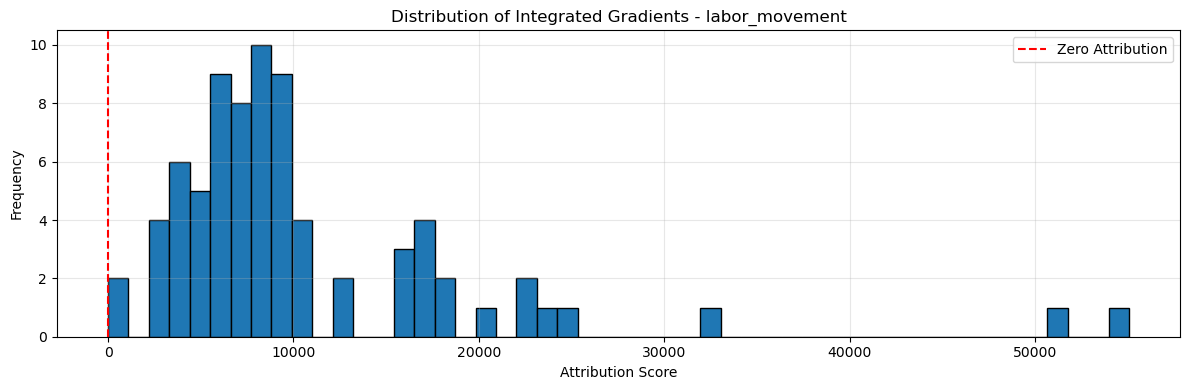


CLASS: POLITICS (Probability: 0.6424)

Attribution Statistics:
  Max: 53041.2148
  Min: 0.0000
  Mean: 10027.3115
  Std: 8814.8984

Top 20 Positive Attributions (Red):
  commissioners       : 53041.2148
  commissioners       : 48218.6680
  ap                  : 30000.1777
  panel               : 23319.3535
  freight             : 22586.0137
  votes               : 21466.4746
  interstate          : 21112.6074
  increases           : 20210.4766
  cast                : 17411.1426
  learned             : 17183.7598
  rates               : 16887.8066
  unusual             : 16318.0752
  commerce            : 16145.3936
  friday              : 16105.5273
  vote                : 15870.6670
  iowa                : 15755.3867
  individual          : 14137.7939
  refused             : 12108.9014
  truck               : 11792.9668
  their               : 9649.0674

Top 20 Negative Attributions (Blue):
  .                   : 2608.0273
  1                   : 2756.4756
  (                   : 27

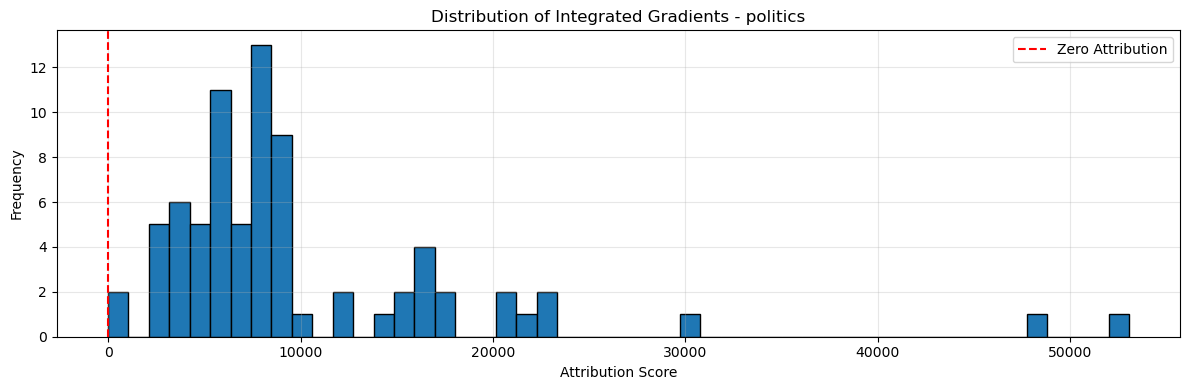

In [25]:
# Visualize for each predicted class
for class_idx in predicted_indices:
    print("\n" + "="*100)
    print(f"CLASS: {category_names[class_idx].upper()} (Probability: {probabilities[0, class_idx]:.4f})")
    print("="*100)
    
    # Get integrated gradients for this class
    ig = all_integrated_grads[class_idx][0].cpu().numpy()[:actual_length]
    
    # Print statistics
    print(f"\nAttribution Statistics:")
    print(f"  Max: {ig.max():.4f}")
    print(f"  Min: {ig.min():.4f}")
    print(f"  Mean: {ig.mean():.4f}")
    print(f"  Std: {ig.std():.4f}")
    
    # Show top 20 positive attributions
    top_indices = np.argsort(ig)[-20:][::-1]
    print(f"\nTop 20 Positive Attributions (Red):")
    for idx in top_indices:
        if tokens[idx] not in ['[CLS]', '[SEP]', '[PAD]']:
            print(f"  {tokens[idx]:20s}: {ig[idx]:.4f}")
    
    # Show top 20 negative attributions
    bottom_indices = np.argsort(ig)[:20]
    print(f"\nTop 20 Negative Attributions (Blue):")
    for idx in bottom_indices:
        if tokens[idx] not in ['[CLS]', '[SEP]', '[PAD]']:
            print(f"  {tokens[idx]:20s}: {ig[idx]:.4f}")
    
    # Visualize highlighted text
    print(f"\nHighlighted Text (hover for attribution scores):")
    print(f"Red = Positive attribution (supports this class)")
    print(f"Blue = Negative attribution (against this class)\n")
    
    html = highlight_tokens(tokens, ig, top_k=20)
    display(HTML(html))
    
    # Plot distribution
    plt.figure(figsize=(12, 4))
    plt.hist(ig, bins=50, edgecolor='black')
    plt.xlabel('Attribution Score')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Integrated Gradients - {category_names[class_idx]}')
    plt.axvline(x=0, color='r', linestyle='--', label='Zero Attribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Summary

This notebook demonstrates how to use Integrated Gradients to interpret text classification predictions:

1. **Positive attributions (red)**: Tokens that increase the probability of the predicted class
2. **Negative attributions (blue)**: Tokens that decrease the probability of the predicted class

The baseline used is an empty text (all padding tokens except CLS and SEP), which helps identify which tokens in the input contribute most to the model's prediction.